# But wait! There's more!

Autoencoders can also be used to remove noise from images.  Here we are using a convolutional autoencoder (i.e. an autoencoder that makes use of a convolutional layer rather than a perceptron (dense) layer).  

The convolutional layer can't learn features from noise because noise by definition has no spatial features. So it can only learn to fit the actual signal. Therefore, we automatically get noise reduction in our autoencoder.

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# Now let's add noise to the MNIST images

In [17]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)  # Make sure we don't get values greater than 1 or less than 0
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

# Here's our noisy MNIST data

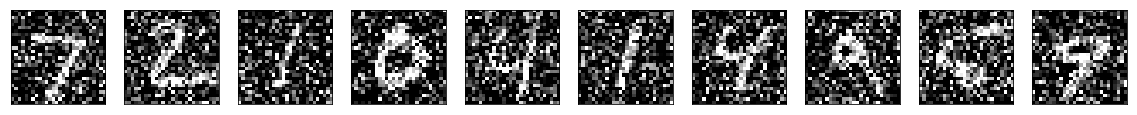

In [19]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Now define an autoencoder based on a set of  2D convolutional layers

In [26]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import EarlyStopping

In [27]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# Fit our model to the noisy training set

Here's the trick, we input the noisy images and tell the autoencoder that we really want the non-noisy images. 

In [29]:
autoencoder.fit(x_train_noisy, x_train,  # input = noisy, output = non-noisy
                epochs=10,
                batch_size=4,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks = [  # Extra functions called during training
                             EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 63s - loss: 0.1015 - val_loss: 0.0979
Epoch 2/10
60000/60000 [==============================] - 65s - loss: 0.0978 - val_loss: 0.0961
Epoch 3/10
60000/60000 [==============================] - 65s - loss: 0.0966 - val_loss: 0.0953
Epoch 4/10
60000/60000 [==============================] - 65s - loss: 0.0959 - val_loss: 0.0953
Epoch 5/10
60000/60000 [==============================] - 66s - loss: 0.0954 - val_loss: 0.0950
Epoch 6/10
60000/60000 [==============================] - 64s - loss: 0.0951 - val_loss: 0.0945
Epoch 7/10
60000/60000 [==============================] - 64s - loss: 0.0948 - val_loss: 0.0941
Epoch 8/10
60000/60000 [==============================] - 65s - loss: 0.0947 - val_loss: 0.0941
Epoch 9/10
60000/60000 [==============================] - 63s - loss: 0.0945 - val_loss: 0.0940
Epoch 10/10
60000/60000 [==============================] - 63s - loss: 0.0944 - val_lo

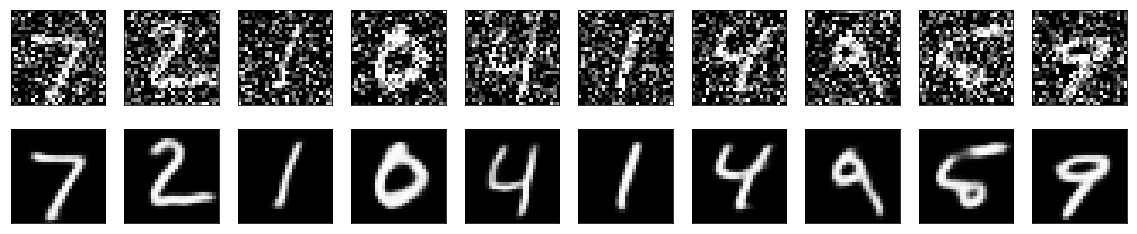

In [36]:
decoded_imgs = autoencoder.predict(x_test_noisy)  # Input our noisy test set and predict

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Voila! A de-noiser for our MNIST dataset.
